In [1]:
import torch
import torch.nn as nn
import numpy as np
import requests
import io
import zipfile
import pandas as pd
from matplotlib import pyplot as plt

from collections import defaultdict
import numpy as np

In [2]:
# Define the model

class MatrixFactorizationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(MatrixFactorizationModel, self).__init__()
        self.item_embeddings = torch.nn.Parameter(torch.FloatTensor(vocab_size, embedding_dim))
        self.context_embeddings = torch.nn.Parameter(torch.FloatTensor(vocab_size, embedding_dim))
        
        nn.init.normal_(self.item_embeddings)
        nn.init.normal_(self.context_embeddings)
   
    def forward(self, x=None):     
        return torch.matmul(self.item_embeddings, self.context_embeddings.t())

In [3]:
#we need to make the special loss function for Skip Gram with Negative Sampling(SGNS)

class SGNSLoss():
    def __init__(self, Nij_matrix, Ni_vector, Nj_vector, N_scalar, num_neg_samples):
        self.Nij_matrix = Nij_matrix
        self.Ni_vector = Ni_vector
        self.Nj_vector = Nj_vector
        self.N_scalar = N_scalar
        self.num_neg_samples = num_neg_samples
        
    def __call__(self, M_hat):
        pos_samples = (self.Nij_matrix * nn.LogSigmoid()(M_hat)).sum()
        
        neg_samples = (self.num_neg_samples / self.N_scalar) * torch.matmul(
            torch.matmul(self.Nj_vector.view(1, -1), nn.LogSigmoid()(-M_hat)),
            self.Ni_vector.view(-1, 1)
        ).sum()
        
        return -(pos_samples + neg_samples) / self.N_scalar


In [4]:
# Load df

def download_extract_zip(file_name):
    with zipfile.ZipFile(file_name, 'r') as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                return pd.read_csv(
                    thefile, 
                    sep=' ', 
                    header=None, 
                    names=['term', 'context', 'Nij']
                )

df = download_extract_zip('data/cooc.zip')


In [5]:
df.head()

,term,context,Nij
0,chief,peace,2072.8
1,produces,venezuela,109.4
2,resources,?,411.2
3,israelis,later,196.2
4,however,list,1395.2


In [6]:
#Load the data from the dataframe
vocab = {"<unk>": 0}
inverse_vocab = ["<unk>"]

# count for words
counts = defaultdict(float)

for row in df.itertuples():
    counts[row.term] += row.Nij

for word in sorted(counts.keys(), key=lambda x: -counts[x]):
    inverse_vocab.append(word)
    vocab[word] = len(vocab)

vocab_size = len(vocab)

# Given the vocabulary mapping above, we now fill in the Nij matrix.
# with large vocabs, this should be done using a *sparse* matrix!!!
Nij_np = np.zeros((vocab_size, vocab_size))
for row in df.itertuples():
    i = vocab[row.term]
    j = vocab[row.context]
    Nij_np[i, j] = row.Nij

In [7]:
Nij_np[0, 1], Nij_np[1, 0]

(0.0, 0.0)

In [8]:
Nij = torch.tensor(Nij_np, dtype=torch.float32)
# marginalize to get the unigram counts
N_scalar = Nij.sum()

# col sums
Ni_vector = Nij.sum(axis=0)

# row sum
Nj_vector = Nij.sum(axis=1)

In [9]:
PMI_np_check = np.array(torch.log((N_scalar * Nij) / (torch.einsum('i,j->ij', Ni_vector, Nj_vector))))
PMI_np = np.array(torch.log(
    (N_scalar * Nij) / (Ni_vector.repeat(vocab_size).view(vocab_size, -1).t() * Nj_vector.repeat(vocab_size).view(vocab_size, -1))
))

In [10]:
PMI_np.shape

(5000, 5000)

In [11]:
PMI_np[:10, :10]

array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [            nan, -5.36919117e-01, -1.70461938e-01,
         1.05970308e-01,  5.60740709e-01, -1.01701491e-01,
         1.91416904e-01, -1.25242188e-03, -6.63214624e-01,
        -2.40376100e-01],
       [            nan, -1.75313801e-01,  3.23851295e-02,
        -4.50757772e-01, -2.05254287e-01,  2.62530386e-01,
        -3.19996998e-02, -3.66229177e-01, -5.96894175e-02,
         4.05826479e-01],
       [            nan,  1.02108844e-01, -4.51396912e-01,
        -2.41316795e+00, -2.00548172e-01, -2.55446255e-01,
         1.30052134e-01, -2.97491431e-01, -1.48173913e-01,
         4.17942315e-01],
       [            nan,  5.56047380e-01, -2.05545306e-01,
        -1.97631210e-01, -5.35332441e-01, -7.04754367e-02,
        -2.46024087e-01, -5.71426868e-01,  2.05666110e-01,
        -3.

Percent -infinities in the PMI matrix: 75.0882%


Statistics of PMIs: 
0.1405 mean, 1.0462 std


/var/folders/mx/41vmmjnx00z2pm2st2dnvjb40000gn/T/ipykernel_74932/3837492147.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap("coolwarm")


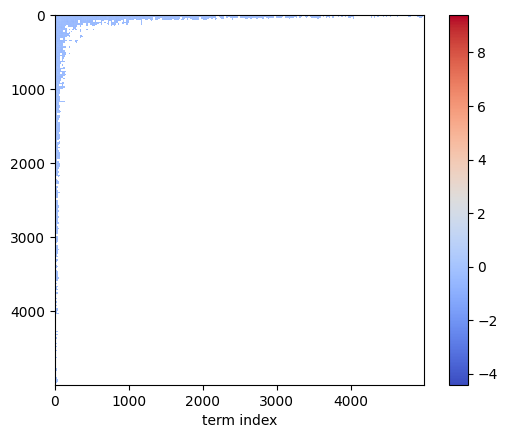

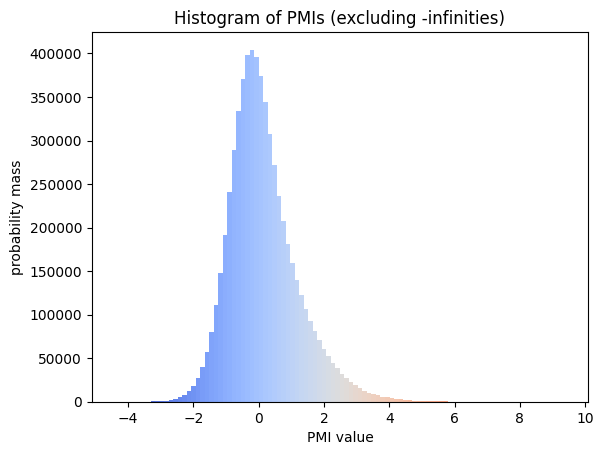

In [12]:
# Visualize the PMI matrix
flat_PMI_np = PMI_np.reshape(-1)
pmi_negativeinf = np.sum(flat_PMI_np == -np.inf)
total = np.prod(PMI_np.shape)
print('Percent -infinities in the PMI matrix: {:.4f}%'.format(
    100 * pmi_negativeinf / total))

_ = plt.figure()
_ = plt.imshow(PMI_np, cmap="coolwarm")
_ = plt.xlabel("term index")
_ = plt.colorbar()

PMI_np[PMI_np == -np.inf] = -4
PMI_np[np.isnan(PMI_np)] = -4
hist_pmis = flat_PMI_np[flat_PMI_np != -4]
_ = plt.figure()
n, bins, patches = plt.hist(hist_pmis, 
                            bins=100,              
                            color="b",
                            alpha=1)
print("Statistics of PMIs: ")
print("{:0.4f} mean, {:0.4f} std".format(np.mean(hist_pmis), 
                                         np.std(hist_pmis)))

cm = plt.cm.get_cmap("coolwarm")
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
_ = plt.xlabel("PMI value")
_ = plt.ylabel("probability mass")
_ = plt.title("Histogram of PMIs (excluding -infinities)")


In [13]:
# look at the biggest PMIs
sorted_indices = np.argsort(PMI_np, axis=None)

print('--- Word pairs with the notable PMIs ---\n')
for i in range(1, 18):
    idx = np.unravel_index(sorted_indices[-i], PMI_np.shape)
    term, context = inverse_vocab[idx[0]], inverse_vocab[idx[1]]
    print('{:8} {:14} (PMI = {:0.4f})'.format(term, context, float(PMI_np[idx])))

--- Word pairs with the notable PMIs ---

|        |              (PMI = 9.3956)
puerto   rico           (PMI = 8.9212)
rico     puerto         (PMI = 8.9182)
las      vegas          (PMI = 8.7001)
vegas    las            (PMI = 8.6940)
bin      laden          (PMI = 8.3084)
optional trim           (PMI = 8.3080)
trim     optional       (PMI = 8.3073)
laden    bin            (PMI = 8.2967)
sri      lanka          (PMI = 8.1917)
lanka    sri            (PMI = 8.1655)
jacques  chirac         (PMI = 8.1147)
chirac   jacques        (PMI = 8.0814)
makeup   racial         (PMI = 8.0538)
racial   makeup         (PMI = 8.0533)
composite nasdaq         (PMI = 8.0391)
nasdaq   composite      (PMI = 8.0328)


In [14]:
# Create the object representing the loss function.
criterion = SGNSLoss(
    Nij_matrix=Nij,
    Ni_vector=Ni_vector,
    Nj_vector=Nj_vector,
    N_scalar=N_scalar,
    num_neg_samples=1
)

embedding_dim = 50

model = MatrixFactorizationModel(vocab_size, embedding_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [15]:
criterion(model()).shape

torch.Size([])

In [16]:
def train_step(model, optimizer, n=1000):
    losses = []
    optimizer.zero_grad()
    M_hat = model()
    loss = criterion(M_hat)
    loss.backward()
    optimizer.step()
    return loss.item()


In [17]:
# Grabs the most similar words to the current term. Scale the vectors and then do an inner product.
def most_similar(term):
    term_idx = vocab[term]
    term_emb = model.item_embeddings[term_idx]
    normalized_embeddings = model.item_embeddings.t() / torch.linalg.norm(model.item_embeddings, axis=1)
    cosine_similarities = torch.matmul(term_emb.view(1, -1), normalized_embeddings)
    similar_word_indices = torch.argsort(cosine_similarities, descending=True).view(-1)
    return [inverse_vocab[idx] for idx in similar_word_indices[1:6]]

In [18]:
# Do the training
import time

start_time = time.process_time()
epoch_start_time = time.process_time()
results = []

num_iterations = 500 + 1
print_every = 50

for i in range(num_iterations):
    loss = train_step(model, optimizer)
    results.append(loss)
    if i % print_every == 0:
        print('\nstep {:4} - loss: {} ({:0.4f} seconds)'.format(
            i, results[-1], time.process_time() - epoch_start_time))
        print('\t similar to "money": ' + " ".join(most_similar("money")))
        print('\t similar to "peace": ' + " ".join(most_similar("peace")))

        epoch_start_time = time.process_time()
        
print('\nTotal time: {:0.4f} seconds.'.format(time.process_time() - start_time))



step    0 - loss: 6.159705638885498 (1.7203 seconds)
	 similar to "money": stock hunt dogs war sure
	 similar to "peace": courts surprise saudi strong provide

step   50 - loss: 1.3189924955368042 (74.8105 seconds)
	 similar to "money": learn worry might manage fees
	 similar to "peace": ties rescue democracy serbia coalition

step  100 - loss: 1.2914180755615234 (72.1950 seconds)
	 similar to "money": jobs pension pay fees customers
	 similar to "peace": negotiations democracy peaceful dialogue implement

step  150 - loss: 1.287269949913025 (72.4381 seconds)
	 similar to "money": pension pay customers benefits jobs
	 similar to "peace": peaceful dialogue democracy negotiations cooperation

step  200 - loss: 1.2856804132461548 (71.0420 seconds)
	 similar to "money": pension pay savings credit cash
	 similar to "peace": peaceful dialogue accord democracy solution

step  250 - loss: 1.2848703861236572 (70.6401 seconds)
	 similar to "money": savings pension cash credit pay
	 similar to "

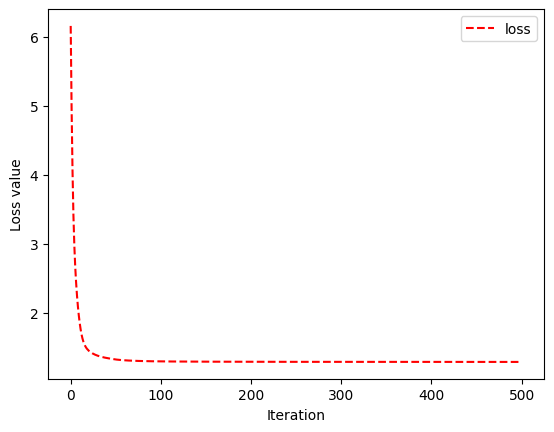

In [19]:
# Visualize the loss over time
x = np.array(list(range(len(results))))
y = np.array(results)

_ = plt.figure()
_ = plt.plot(x, y, '--r', label="loss")
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss value")
_ = plt.legend()

In [20]:
# manual qualitative inspection
for w in ["drive", "america", "east", "soviet", "belgium", "brussels", "1914"]:
    print("{:10}: {}".format(w, " ".join(most_similar(w))))

drive     : run stop catch turn fast
america   : asia europe african asian japan
east      : west southeast eastern northeast middle
soviet    : communist russian polish turkish yugoslavia
belgium   : austria finland hungary netherlands denmark
brussels  : vienna paris rome munich taipei
1914      : 1915 1917 1916 1920 1923
